In [1]:
import math
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame,Series

In [2]:
rho = 2700 #kg/m³
cp = 900 #J/kg.°C
k = 230 #W/m°C
ri = 0.050 #m
re = 0.056 #m
T_infinito = 80 #°C
h = 20000 #W/m².°C
Ti = 80 #°C
H = 1 #m²

pi = math.pi

In [3]:
def T_sup(t):
    T_sup = 150 + 50 * math.cos(50 * pi * t)
    return T_sup

In [33]:
mesh = 5
deltar = (re-ri)/(mesh-1)

time = 592
deltat = 0.002

In [34]:
def TDMA(A,B):   
# o vetor de coeficientes P poderia ser definida
#no procedimento principal, mas para fazer um método 
#genérico de resolução TDMA ela é definida aqui
    P = np.zeros(mesh)
    Q = np.zeros(mesh)
    #T = np.zeros((mesh,1))  
    T = np.zeros(mesh)
    Matrix_P = np.zeros((mesh,mesh))
    Matrix_Q = np.zeros((mesh,1))
    
    #print(B)
    
    Q[0] = B[0]/A[0,0]  
    P[0] = A[0,1]/A[0,0]
    

    for i in range(1,mesh):        
        Q[i] = (B[i] + A[i,i-1]*Q[i-1])/(A[i,i] - A[i,i-1]*P[i-1])
        if (i<mesh-1):
            P[i] = A[i,i+1]/(A[i,i] - A[i,i-1]*P[i-1])
        
        
    '''
    for i in range(mesh):
        Matrix_P[i,i] = 1            
        Matrix_Q[i,0] = Q[i]
        
        if (i< mesh-1):
            Matrix_P[i,i+1] = -P[i]
    T = solve(Matrix_P,Matrix_Q)  
    '''
    T[mesh-1] = Q[mesh-1]
    for i in range(mesh-2,-1,-1):
        T[i] = P[i] *T[i+1] + Q[i]
        
       
    
    
    #print(Matrix_Q)
    #return T.transpose()
    return T


In [47]:
#método numérico
T = np.zeros((time,mesh))
q = np.zeros((time,mesh))
q_A = np.zeros((time,mesh))
#M = rho * H * deltar
x_plot = np.zeros(mesh)
t_plot = np.zeros(time)

Matrix_coef_a = np.zeros((mesh,mesh))
Matrix_coef_b = np.zeros((mesh,1))

x_plot[0] = ri
t_plot[0] = 0
for volume in range(mesh):
    T[0,volume] = Ti 
    if volume>0:
        x_plot[volume] = x_plot[volume-1] +deltar

T[0,0] = T_sup(0)
'''
for t in range (time):
    if t>0:
        t_plot[t] = t_plot[t-1] + deltat
'''
#Definição da matriz de coeficientes        
for r in range(mesh): 
    if (r == 0):
        ap = 1                
        Matrix_coef_a[0,0] = ap
                    
    if (r > 0) and (r < mesh-1):
        ae = k*H*2*pi*(x_plot[r]+deltar/2)/deltar #malha igualmente espaçada
        aw = k*H*2*pi*(x_plot[r]-deltar/2)/deltar
        ap0 = rho*cp*pi*H*((x_plot[r]+deltar/2)**2 - (x_plot[r]-deltar/2)**2)/deltat
        ap = ap0 + ae + aw
            
        Matrix_coef_a[r,r-1] = aw #coloquei como positivo para utilizar no TDMA
        Matrix_coef_a[r,r+1] =ae #não precisaria definir matrizes de coef A e B,
        Matrix_coef_a[r,r] = ap #porém fiz essa opção para obter um método
        #Matrix_coef_b[r,0] = b #genérico de TDMA
            
            
    if (r == mesh-1):
        aw = k*H*2*pi*(x_plot[r]-deltar/2)/deltar
        ap0 = rho*cp*pi*H*(x_plot[r]**2 - (x_plot[r]-deltar/2)**2)/deltat
        ap = ap0 + aw + 2*pi*H*h*x_plot[r]
        #b = 2*pi*re*H*h*T_infinito
            
        Matrix_coef_a[r,r-1] = aw
        Matrix_coef_a[r,r] = ap
t = 1 
eps = 1
while (eps > 1e-3):            
#for t in range(1,time):
    for r in range(mesh):
        if (r==0):            
            b = T_sup(t*deltat)            
            
            Matrix_coef_b[0,0] = b 
            
        if (r > 0) and (r < mesh-1):
            ap0 = rho*cp*pi*H*((x_plot[r]+deltar/2)**2 - (x_plot[r]-deltar/2)**2)/deltat
            
            Matrix_coef_b[r,0] = ap0*T[t-1,r]
            
        if (r == mesh-1):
            ap0 = rho*cp*pi*H*(x_plot[r]**2 - (x_plot[r]-deltar/2)**2)/deltat
            b = 2*pi*re*H*h*T_infinito
            Matrix_coef_b[r,0] = b + ap0*T[t-1,r]
        
        
    T[t,:] = TDMA(Matrix_coef_a,Matrix_coef_b)
       
    #if (t_plot[t] > 0.04):
    eps = abs(T[t,mesh-1] - T[(t-(0.04/deltat)),mesh-1])
    t_plot[t] = t_plot[t-1] + deltat
    t += 1
    
for t in range(time):
    for r in range(mesh-1):
        q[t,r] = k*2*pi*(x_plot[r]-deltar/2)*H*(T[t,r]-T[t,r+1])
        q_A[t,r] = k*(T[t,r]-T[t,r+1])
    q[t,mesh-1] = h*2*pi*re*H*(T[t,mesh-1] - T_infinito)
    q_A[t,mesh-1] = h*(T[t,mesh-1] - T_infinito)        
                

C:\Users\Gusttav\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [48]:
q

array([[  8.54073379e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  7.76970036e+03,   5.71143975e+02,   4.19500778e+01,
          2.86734059e+00,   4.24776689e+01],
       [  6.78401321e+03,   9.92698872e+02,   1.09159242e+02,
          9.76534479e+00,   1.86226213e+02],
       ..., 
       [ -2.72948169e+03,   1.48562377e+02,   5.45340200e+02,
          4.93635625e+02,   3.18039595e+05],
       [ -2.68392579e+03,  -3.36997646e+01,   4.99103822e+02,
          4.90169249e+02,   3.18425681e+05],
       [ -2.33040896e+03,  -1.67385726e+02,   4.49323318e+02,
          4.84064720e+02,   3.18712986e+05]])

In [49]:
t_plot

array([ 0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,  0.012,  0.014,
        0.016,  0.018,  0.02 ,  0.022,  0.024,  0.026,  0.028,  0.03 ,
        0.032,  0.034,  0.036,  0.038,  0.04 ,  0.042,  0.044,  0.046,
        0.048,  0.05 ,  0.052,  0.054,  0.056,  0.058,  0.06 ,  0.062,
        0.064,  0.066,  0.068,  0.07 ,  0.072,  0.074,  0.076,  0.078,
        0.08 ,  0.082,  0.084,  0.086,  0.088,  0.09 ,  0.092,  0.094,
        0.096,  0.098,  0.1  ,  0.102,  0.104,  0.106,  0.108,  0.11 ,
        0.112,  0.114,  0.116,  0.118,  0.12 ,  0.122,  0.124,  0.126,
        0.128,  0.13 ,  0.132,  0.134,  0.136,  0.138,  0.14 ,  0.142,
        0.144,  0.146,  0.148,  0.15 ,  0.152,  0.154,  0.156,  0.158,
        0.16 ,  0.162,  0.164,  0.166,  0.168,  0.17 ,  0.172,  0.174,
        0.176,  0.178,  0.18 ,  0.182,  0.184,  0.186,  0.188,  0.19 ,
        0.192,  0.194,  0.196,  0.198,  0.2  ,  0.202,  0.204,  0.206,
        0.208,  0.21 ,  0.212,  0.214,  0.216,  0.218,  0.22 ,  0.222,
      

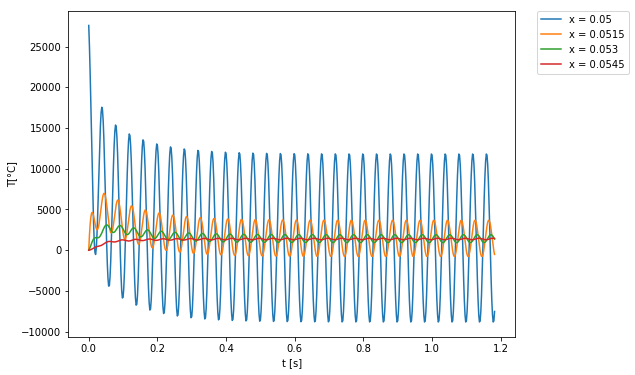

In [51]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
axis = fig.add_subplot(111)  

for x in range(mesh-1):    
    #axis.plot(t_plot,T[:,x],label='x = '+str(x_plot[x]))
    axis.plot(t_plot,q_A[:,x],label='x = '+str(x_plot[x]))
    
axis.set_ylabel('T[°C]')
axis.set_xlabel('t [s]')
axis.set_title('')
axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axis.set_ylim(30,100)
#axis.set_xlim(-0.05,0.45)
